In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
downloaded = drive.CreateFile({'id':"1KNtki5ezJp_COUw0phbusAieQXvRrL5U"})   # replace the id with id of file you want to access
downloaded.GetContentFile('web_categ_final.csv')
new_train=pd.read_csv("web_categ_final.csv")
new_train.head()

Webpage_id   Tag                                               text
0           1  news  b'    Skip to main content                    ...
1           2  news  b'    Skip to main content                    ...
2           3  news  b'    Skip to main content                    ...
3           4  news  b"    Skip to main content                    ...
4           5  news  b"    Skip to main content                    ...

In [4]:
new_train["Tag"].value_counts()

others            17417
news               7992
publication        7705
profile            5196
conferences        4666
forum              4503
clinicalTrials     2839
thesis             1800
guidelines         1329
Name: Tag, dtype: int64

**Preprocessing**
1.The raw data is messy. It contains links, non ascii characters, punctuations, numbers, extra spaces, etc.

2.So, Data Pre-processing is the most important step prior to the model building in which we remove all the unnecessary qualities from the data.


1.**Cleaning**
**Steps**

1.Convert to lowercase

2.Removal of links

3.Removal of text inside {} and ()

4.Removal of special characters, punctuations, numbers

5.Removal of short words

In [0]:
for text in new_train["text"][:5]:
  print("\n\n",text)



 b'    Skip to main content                                    Twitter  LinkedIn      Search           Top Menu    DDF 2017    FierceBiotech    Jobs    Resources    Events    Subscribe                  Main navigation    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partnering    Drug Safety      Marketing    Regulatory    DTC Advertising    Digital and Social Media    Data and Analytics    Launches      Pharma Asia    M&A    R&D    Regulatory    Sales and Marketing    Financials    Manufacturing      Animal Health    R&D    M&A    Regulatory    Veterinarian    Financials    Vaccines      Drug Delivery    R&D    Regulatory    Partnering      Vaccines    Deals    Infectious Diseases    R&D    Regulatory        Main navigation - Mobile    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partnering    Drug Sa

In [0]:
stop_words=set(stopwords.words("english"))

def text_cleaner(text):
  # Converting to lowercase
  newstring=text.lower()
  # removing links
  newString=re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&\%)*\b',"",newstring)
  #removing words inside ()
  newString=re.sub(r'\([^)]*\)',"",newString)
  #removing words inside []
  newString=re.sub(r'\{[^)]*\}',"",newString)
  #removing non alphabetic characters
  newString=re.sub("[^a-zA-Z]"," ",newString)
  #removing stopwords
  tokens=[w for w in newString.split() if not w in stop_words]
  long_words=[]
  for i in tokens:
    #removing short words
    if len(i)>=4:
      long_words.append(i)
  return (" ".join(long_words)).strip()


In [5]:
text1 = new_train['text'][2]
clean_text1 = text_cleaner(text1)
print("Before cleaning:\n",text1)
print("After cleaning:\n",clean_text1)

Before cleaning:
 b'    Skip to main content                                    Twitter  LinkedIn      Search           Top Menu    DDF 2017    FierceBiotech    Jobs    Resources    Events    Subscribe                  Main navigation    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partnering    Drug Safety      Marketing    Regulatory    DTC Advertising    Digital and Social Media    Data and Analytics    Launches      Pharma Asia    M&A    R&D    Regulatory    Sales and Marketing    Financials    Manufacturing      Animal Health    R&D    M&A    Regulatory    Veterinarian    Financials    Vaccines      Drug Delivery    R&D    Regulatory    Partnering      Vaccines    Deals    Infectious Diseases    R&D    Regulatory        Main navigation - Mobile    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partne

In [0]:
cleaned_text=[]
for i in new_train["text"]:
  cleaned_text.append(text_cleaner(i))

In [8]:
cleaned_text

['skip main content twitter linkedin search menu fiercebiotech jobs resources events subscribe main navigation pharma regulatory financials corporate legal manufacturing outsourcing regulatory supply chain partnering drug safety marketing regulatory advertising digital social media data analytics launches pharma asia regulatory sales marketing financials manufacturing animal health regulatory veterinarian financials vaccines drug delivery regulatory partnering vaccines deals infectious diseases regulatory main navigation mobile pharma regulatory financials corporate legal manufacturing outsourcing regulatory supply chain partnering drug safety marketing regulatory advertising digital social media data analytics launches pharma asia regulatory sales marketing financials manufacturing animal health regulatory veterinarian financials vaccines drug delivery regulatory partnering vaccines deals infectious diseases regulatory marketing tecfidera gilenya aubagio battle share heat tracy staton

### Label Encoding


In [7]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transfor m(new_train["Tag"])
print(y)

[4 4 4 ... 6 6 6]


#### Validation Split

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_text,y,test_size=0.3,random_state=0,shuffle=True)

### Padding

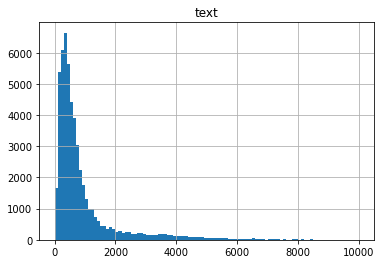

In [9]:
import matplotlib.pyplot as plt

text_word_count=[]
for i in cleaned_text:
  text_word_count.append(len(i.split()))

length_df=pd.DataFrame({"text":text_word_count})

length_df.hist(bins=100,range=(0,10000))
plt.show()

From the above histogram, we observe that most of the sequences fall under the length of 500. So, let us fix maximum length of sequence to 500.

In [0]:
max_len=500

#### Because of the way NN work, we need to convert each text in the form of sequences of tokens.


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer()
#creating index for a word
tokenizer.fit_on_texts(list(x_tr))

#converting word seq to integer seq

x_tr= tokenizer.texts_to_sequences(x_tr)
x_val=tokenizer.texts_to_sequences(x_val)

#padding with zero

x_tr= pad_sequences(x_tr,maxlen=max_len,padding="post")
x_val=pad_sequences(x_val,maxlen=max_len,padding="post")

vocabulary =len(tokenizer.word_index)+1

print("Vocabulary size:", vocabulary)

Using TensorFlow backend.


Vocabulary size: 467840


In [12]:
#Sequence encoding and padding

x_tr[7128]

array([   364,    178,     91,    959,   2157,    362,     35,   1506,
          419,   1398,   1561,    419,    319,    319,   2587,    319,
         3590,   1852,    357,     77,    279,     77,    141,    123,
          163,    371,    279,     48,     71,     10,    809,    321,
          447,     33,    212,     33,   7674,   5287,   2394,    140,
           70,    380,    350,     19,     10,    312,     99,    212,
         2779,   1987,   1225,     91,    268,    357,    160,    323,
         7047,     44,   8007,    166,   2979,     16,    106,     16,
          226,     91,      7,    565,     59,   1529,     48,      7,
          565,     59,     16,    180,     16,    265,      7,    232,
            7,    202,    415,    163,   1831,    153,    156,      7,
           62,    162,    111,    826,   5202,     70,   3962,    153,
         2642,    530,      9,   2642,   1236,      9,    709,    273,
           93,    281,    843,   3025,    843,    622,   4312,     14,
      

In [18]:
#showing word index
tokenizer.word_index

{'cancer': 1,
 'health': 2,
 'research': 3,
 'patients': 4,
 'google': 5,
 'pubmed': 6,
 'article': 7,
 'cells': 8,
 'view': 9,
 'information': 10,
 'scholar': 11,
 'clinical': 12,
 'cell': 13,
 'study': 14,
 'care': 15,
 'search': 16,
 'conference': 17,
 'medical': 18,
 'contact': 19,
 'treatment': 20,
 'patient': 21,
 'data': 22,
 'medicine': 23,
 'news': 24,
 'university': 25,
 'disease': 26,
 'also': 27,
 'science': 28,
 'international': 29,
 'results': 30,
 'development': 31,
 'home': 32,
 'journal': 33,
 'time': 34,
 'email': 35,
 'using': 36,
 'management': 37,
 'group': 38,
 'share': 39,
 'site': 40,
 'expression': 41,
 'center': 42,
 'services': 43,
 'find': 44,
 'analysis': 45,
 'human': 46,
 'products': 47,
 'authors': 48,
 'policy': 49,
 'hospital': 50,
 'global': 51,
 'overview': 52,
 'central': 53,
 'free': 54,
 'first': 55,
 'tumor': 56,
 'related': 57,
 'studies': 58,
 'abstract': 59,
 'society': 60,
 'people': 61,
 'full': 62,
 'support': 63,
 'used': 64,
 'media': 65,

In [0]:
from keras.utils.np_utils import to_categorical

y_tr=to_categorical(y_tr,num_classes=9)
y_val=to_categorical(y_val,num_classes=9)

### Model Building

- There are 2 ways of building models in keras i.e Sequential API and Functional API.

1. Sequential API
2. Functional API

  -  Sequential API
   
   In this we can add only one model in the same layer.

 - Functional API

  In this we can add multiple models in the same layer.


- Keras embedding layer

  Embedding layer creates the embedding matrix which maps the integer to the embeddings. These embeddings are learnt during back propagation.

- Dropout

  Dropout is a regularization technique which randomly dropouts neurons from the layer and the connections to these neurons are disabled and not involved in forward as well as the backward propagation.


- Recurrent dropout

  This is used in Recurrent Neural Networks to dropout recent hidden units between the time stamps.
  

**1. LSTM MODEL**

Calling clear_session() releases the global graph state that Keras is holding on to; resets the counters used for naming layers and variables in Keras; and resets the learning phase. This helps avoid clutter from old models and layers, especially when memory is limited, and a common use-case for clear_session is releasing memory when building models and layers in a loop.

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
K.clear_session()

# LSTM model

model=Sequential()
model.add(Embedding(vocabulary,100,input_length=max_len,trainable=True,mask_zero=True))
model.add(LSTM(300,dropout=0.1,recurrent_dropout=0.2))
model.add(Dense(64,activation="relu"))
model.add(Dense(9,activation="softmax"))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          46784000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 585       
Total params: 47,285,049
Trainable params: 47,285,049
Non-trainable params: 0
_________________________________________________________________
None


Now I will compile the model by specifying optimizer,loss and metrics.

- Here categorical_crossentropy will be used 

In [0]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["acc"])

**Callbacks**

- Here 2 callbacks have been defined i.e Early Stopping and model checkpoint.


**Early Stopping**

- This will help us in stopping the neural network at the right time. The training of neural network is stopped as the validation loss keeps increasing for some epochs which is specified using patience parameter.

**Model Checkpoint**

- The model obtained at the end of training is not the best model since the training of the model is stopped after increase in validation loss.

- This helps in saving the best model at every epoch which can retrieve while making predictions.

In [0]:
es=EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=2)
mc=ModelCheckpoint("best_model.h5",monitor="val_loss",mode="min",save_best_only=True,verbose=1)

In [17]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=1200,epochs=10,validation_data=(np.array(x_val),np.array(y_val)),verbose=1,callbacks=[es,mc])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 37412 samples, validate on 16035 samples
Epoch 1/10
37412/37412 [==============================] - 2011s 54ms/step - loss: 1.8909 - acc: 0.3535 - val_loss: 1.4276 - val_acc: 0.5182

Epoch 00001: val_loss improved from inf to 1.42760, saving model to best_model.h5
Epoch 2/10
37412/37412 [==============================] - 1998s 53ms/step - loss: 1.0207 - acc: 0.6556 - val_loss: 0.6678 - val_acc: 0.7758

Epoch 00002: val_loss improved from 1.42760 to 0.66781, saving model to best_model.h5
Epoch 3/10
37412/37412 [==============================] - 2020s 54ms/step - loss: 0.5098 - acc: 0.8356 - val_loss: 0.4291 - val_acc: 0.8601

Epoch 00003: val_loss improved from 0.66781 to 0.42913, saving model to best_model.h5
Epoch 4/10
37412/37412 [==============================] - 1920s 51ms/step - loss: 0.3620 - acc: 0.8819 - val_loss: 0.3741 - val_acc: 0.8698

Epoch 00004: val_loss improved from 0.42913 to 0.37411, saving model to best_model.h5
Epoch 5/10
37412/37412 [======================

**Diagnostic Plots**
- The diagnostic plots helps in understanding the performance of the model over time

In [0]:
from matplotlib import pyplot

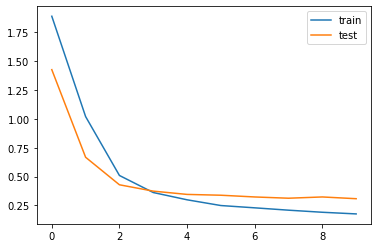

In [23]:
pyplot.plot(history.history["loss"],label="train")
pyplot.plot(history.history["val_loss"],label="test")
pyplot.legend()
pyplot.show()

- From the above plot, we can infer that the valdiation loss has increased after epoch 8 ,hence the training is stopped at the end of epoch 10.

- We make use of model checkpoint to take the best model


In [24]:
from keras.models import load_model
model=load_model("best_model.h5")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [40]:
from sklearn.metrics import classification_report

y_pred=model.predict_classes(np.array(x_val))
y_true=np.argmax(y_val,axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       868
           1       0.91      0.90      0.90      1408
           2       0.99      0.99      0.99      1364
           3       0.88      0.85      0.87       389
           4       0.87      0.81      0.84      2425
           5       0.87      0.92      0.89      5241
           6       0.87      0.85      0.86      1556
           7       0.95      0.92      0.94      2257
           8       0.99      1.00      1.00       527

    accuracy                           0.90     16035
   macro avg       0.92      0.91      0.92     16035
weighted avg       0.90      0.90      0.90     16035

